In [0]:
COLAB = True # NOTE change me if not running on Colab :D

## Importing libs

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [4]:
if COLAB:
    try:
        # Colab only
        %tensorflow_version 2.x
    except Exception:
        pass

TensorFlow 2.x selected.


In [5]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [0]:
import warnings
from time import time, strftime

In [7]:
strftime('%X')

'20:50:04'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [8]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
if COLAB:
    PATH_TO_DATA = os.path.join("drive", "My Drive", "unicamp", "%ic", "mc886", "fashion-mnist-dataset")
    !ls drive/My\ Drive/unicamp/%ic/mc886/fashion-mnist-dataset/
else:
    PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")
    !ls ../fashion-mnist-dataset/

fashion-mnist_test.csv	fashion-mnist_train.csv  README.txt


In [0]:
# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [0]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [0]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [13]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


In [0]:
# pd.DataFrame(validation_dataset).to_csv(os.path.join(PATH_TO_DATA, "train_dataset.csv"))
# pd.DataFrame(validation_dataset).to_csv(os.path.join(PATH_TO_DATA, "validation_dataset.csv"))
# # obs.: we only save the train/validation split we performed on the training set
# #       the test dataset is the same from https://www.dropbox.com/s/qawunrav8ri0sp4/fashion-mnist-dataset.zip

## Separate labels and images

In [14]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [15]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [0]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [17]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [0]:
xs_train = xs_train.astype('float32') / 255.0
xs_val   = xs_val.astype('float32')   / 255.0
xs_test  = xs_test.astype('float32')  / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [19]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [20]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [0]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [22]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [23]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


_obs.:_ `Y_foo` is only a one-hot encoded version of `ys_foo` (so we use `ys_foo` in some places below, to avoid calling `np.argmax`)

## Add helper functions

In [0]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [0]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

In [0]:
MAX_EPOCHS = 64
BATCH_SIZE = 512
TF_VERBOSE = 1 # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [0]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = ([keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
                 if not early_stopping else
                 [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)])
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=TF_VERBOSE
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

### 1.1. MLP

In [0]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [0]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

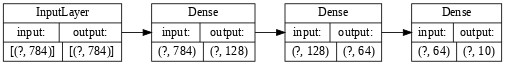

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

In [36]:
strftime('%X')

'20:50:15'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 2s 35us/sample - loss: 0.6825 - accuracy: 0.7682 - val_loss: 0.4622 - val_accuracy: 0.8398
Epoch 2/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.4277 - accuracy: 0.8535 - val_loss: 0.4158 - val_accuracy: 0.8594
Epoch 3/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3836 - accuracy: 0.8691 - val_loss: 0.3834 - val_accuracy: 0.8692
Epoch 4/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3581 - accuracy: 0.8774 - val_loss: 0.3646 - val_accuracy: 0.8728
Epoch 5/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3323 - accuracy: 0.8850 - val_loss: 0.3471 - val_accuracy: 0.8797
Epoch 6/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3172 - accuracy: 0.8894 - val_loss: 0.3670 - val_accuracy: 0.8739
Epoch 7/64
48000/48000 [===========

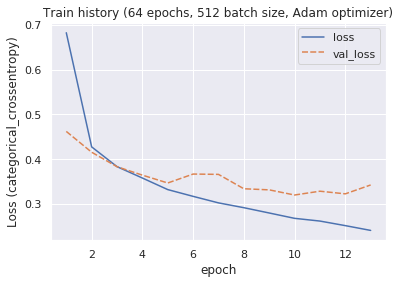

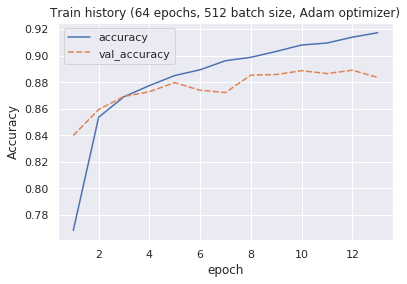

In [37]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val)

In [38]:
strftime('%X')

'20:50:25'

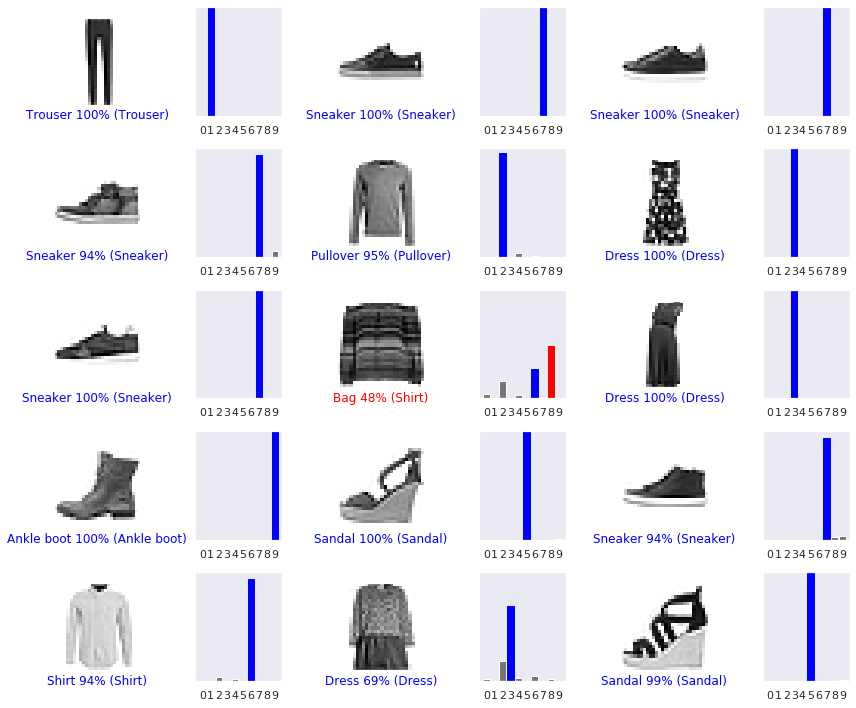

In [39]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

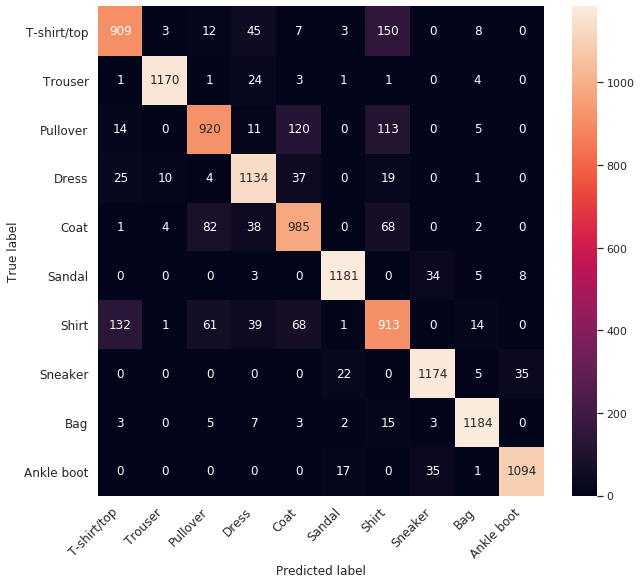

In [40]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

### 1.2. CNN

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [0]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [43]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [44]:
conv_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

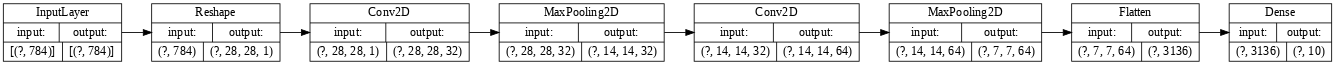

In [45]:
tf.keras.utils.plot_model(conv_model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

In [46]:
strftime('%X')

'20:50:31'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 4s 93us/sample - loss: 0.7316 - accuracy: 0.7494 - val_loss: 0.4837 - val_accuracy: 0.8357
Epoch 2/64
48000/48000 [==============================] - 2s 51us/sample - loss: 0.4390 - accuracy: 0.8523 - val_loss: 0.4015 - val_accuracy: 0.8677
Epoch 3/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3920 - accuracy: 0.8692 - val_loss: 0.3673 - val_accuracy: 0.8807
Epoch 4/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3623 - accuracy: 0.8809 - val_loss: 0.3714 - val_accuracy: 0.8764
Epoch 5/64
48000/48000 [==============================] - 2s 52us/sample - loss: 0.3454 - accuracy: 0.8865 - val_loss: 0.3582 - val_accuracy: 0.8825
Epoch 6/64
48000/48000 [==============================] - 2s 51us/sample - loss: 0.3258 - accuracy: 0.8943 - val_loss: 0.3307 - val_accuracy: 0.8942
Epoch 7/64
48000/48000 [===========

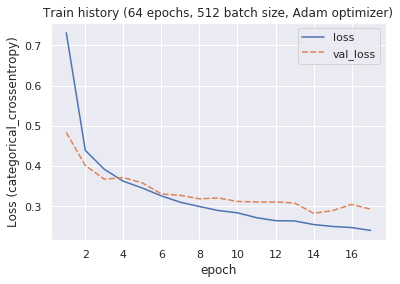

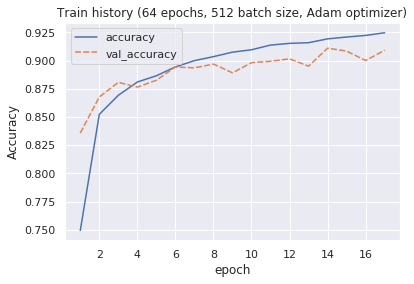

In [47]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val)

In [48]:
strftime('%X')

'20:51:16'

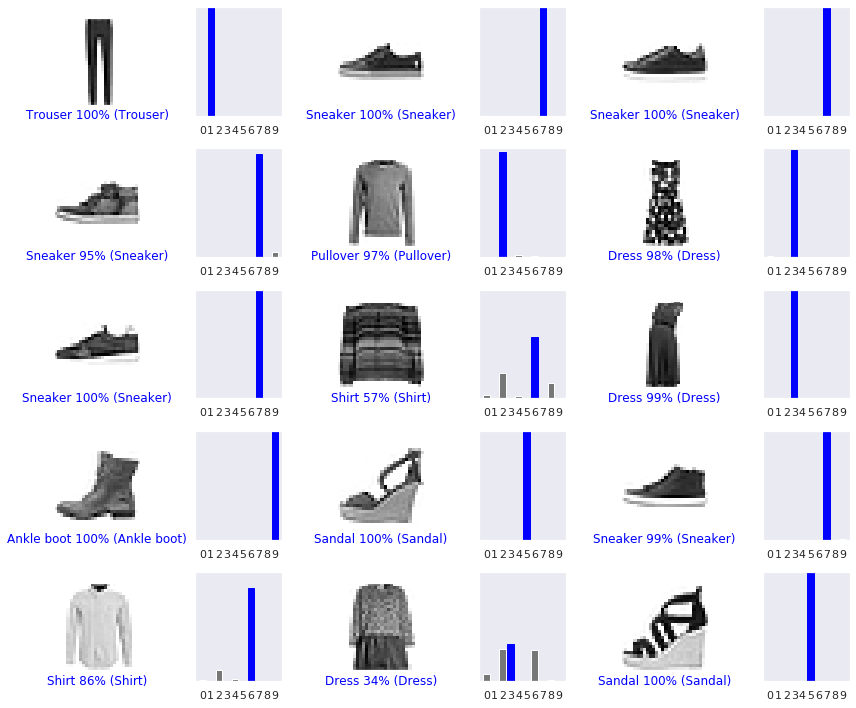

In [49]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

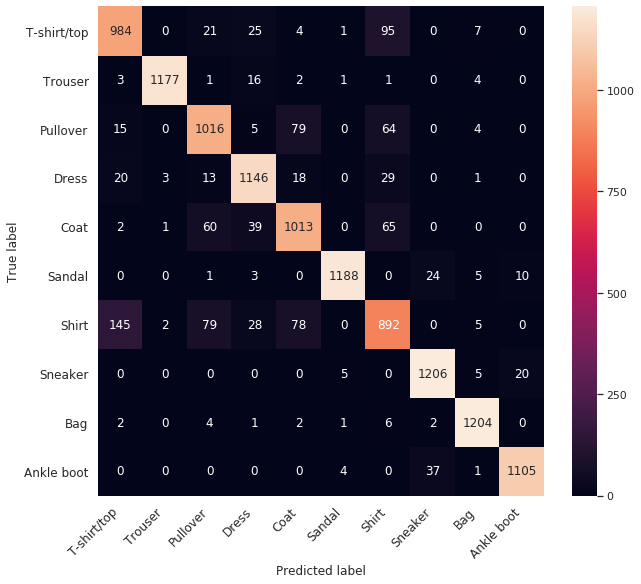

In [50]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [0]:
from sklearn.decomposition import PCA

In [0]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [53]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [0]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [0]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

### 2.1. 99% explained variance

In [56]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.9900491237640381 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 24us/sample - loss: 0.8333 - accuracy: 0.7318 - val_loss: 0.4465 - val_accuracy: 0.8505
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3897 - accuracy: 0.8706 - val_loss: 0.3894 - val_accuracy: 0.8702
Epoch 3/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3303 - accuracy: 0.8903 - val_loss: 0.3706 - val_accuracy: 0.8775
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2934 - accuracy: 0.9043 - val_loss: 0.3591 - val_accuracy: 0.8800
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2656 - accuracy: 0.9144 - val_loss: 0.3521 - val_accuracy: 0.8856
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2419 - accuracy: 0.9229 - val_loss: 0.3492 - val_accuracy: 0.8823
Epoch 7/64
48000/48000 [===========

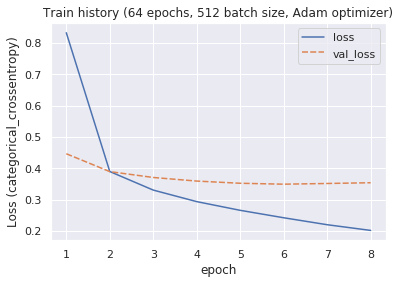

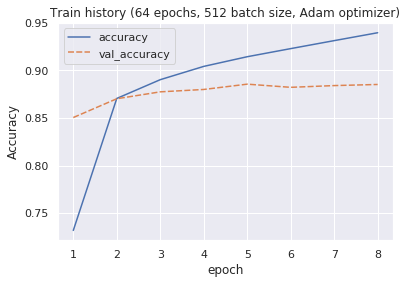

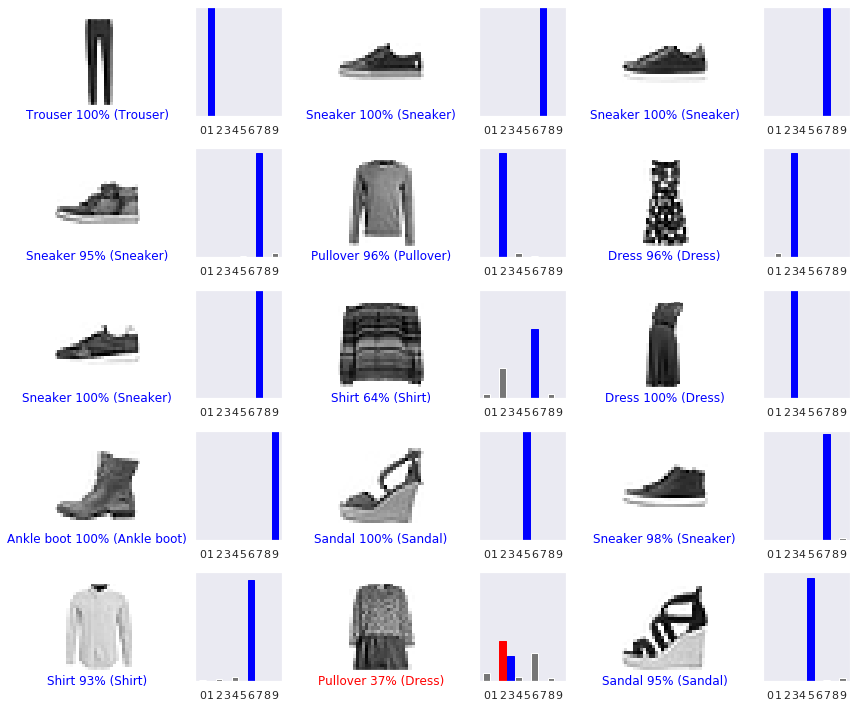

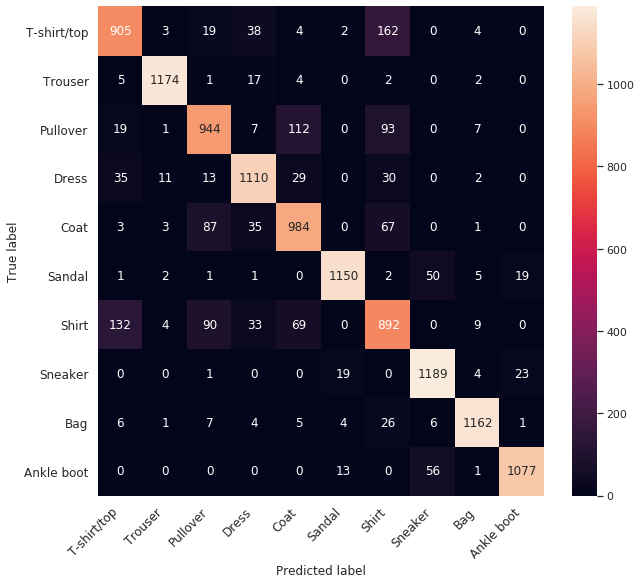

In [57]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

### 2.2. 95% explained variance

In [58]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9501577615737915 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.8551 - accuracy: 0.7254 - val_loss: 0.4686 - val_accuracy: 0.8405
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4183 - accuracy: 0.8587 - val_loss: 0.4035 - val_accuracy: 0.8625
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3657 - accuracy: 0.8764 - val_loss: 0.3777 - val_accuracy: 0.8707
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3337 - accuracy: 0.8879 - val_loss: 0.3651 - val_accuracy: 0.8757
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3105 - accuracy: 0.8953 - val_loss: 0.3509 - val_accuracy: 0.8801
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.2917 - accuracy: 0.9027 - val_loss: 0.3422 - val_accuracy: 0.8827
Epoch 7/64
48000/48000 [===========

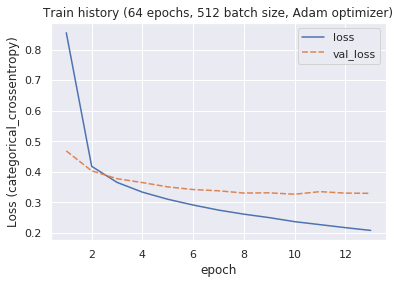

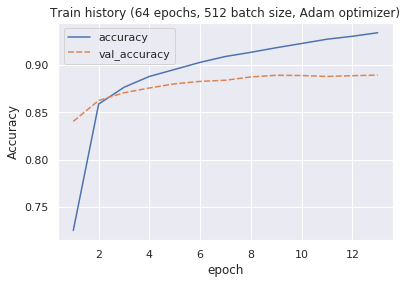

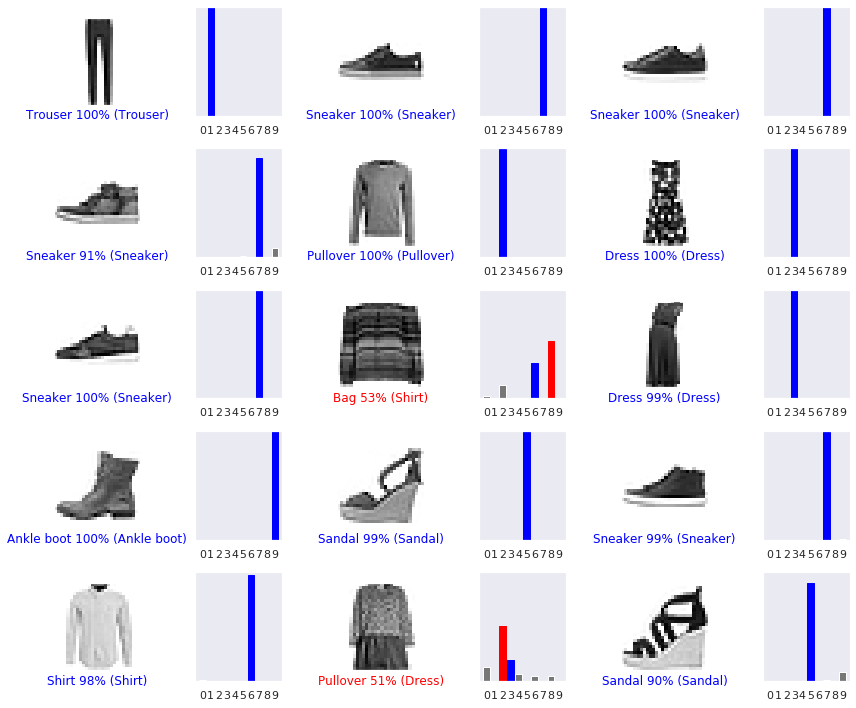

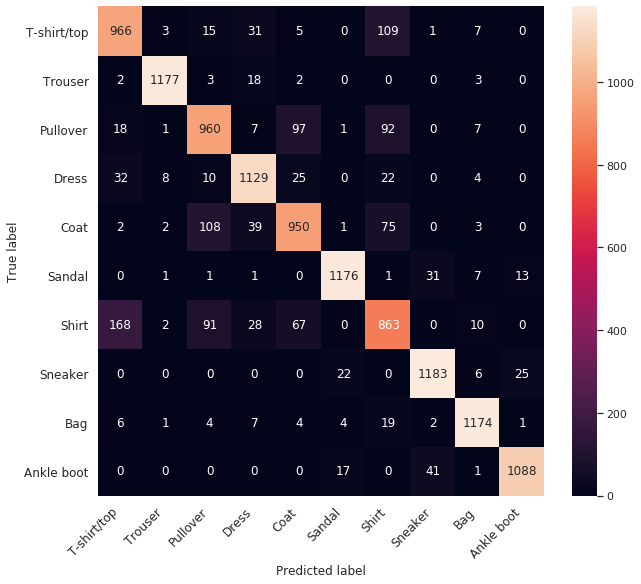

In [59]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

### 2.3. 90% explained variance

In [60]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006989598274231 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 29us/sample - loss: 0.9549 - accuracy: 0.7001 - val_loss: 0.5031 - val_accuracy: 0.8291
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4510 - accuracy: 0.8463 - val_loss: 0.4286 - val_accuracy: 0.8519
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3976 - accuracy: 0.8644 - val_loss: 0.4018 - val_accuracy: 0.8638
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3703 - accuracy: 0.8736 - val_loss: 0.3868 - val_accuracy: 0.8668
Epoch 5/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.3491 - accuracy: 0.8806 - val_loss: 0.3770 - val_accuracy: 0.8706
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3343 - accuracy: 0.8854 - val_loss: 0.3658 - val_accuracy: 0.8758
Epoch 7/64
48000/48000 [===========

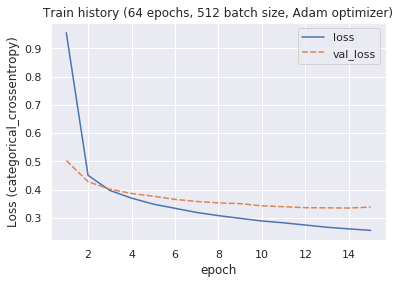

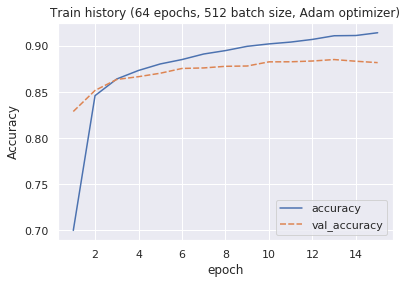

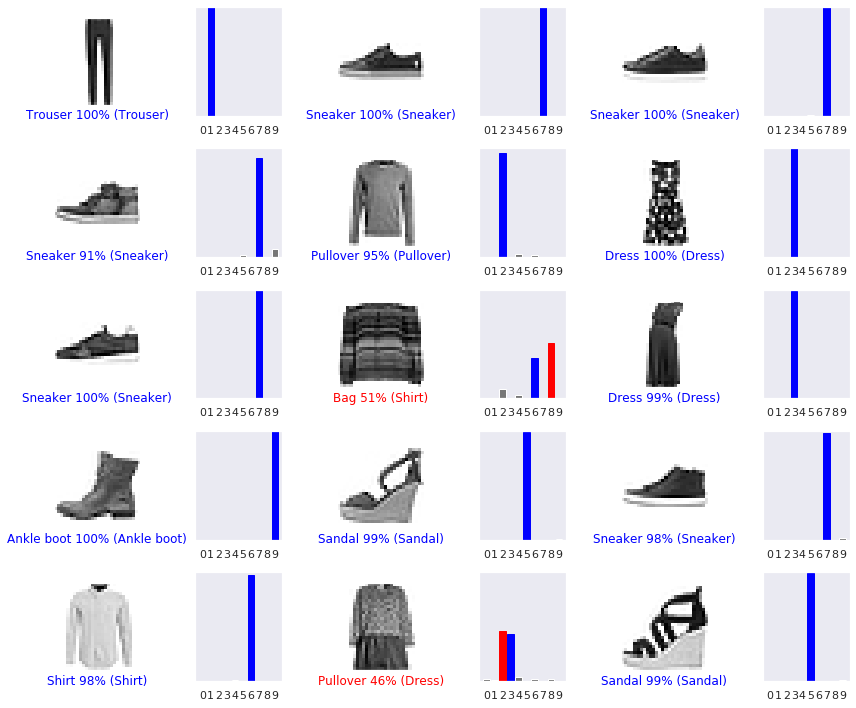

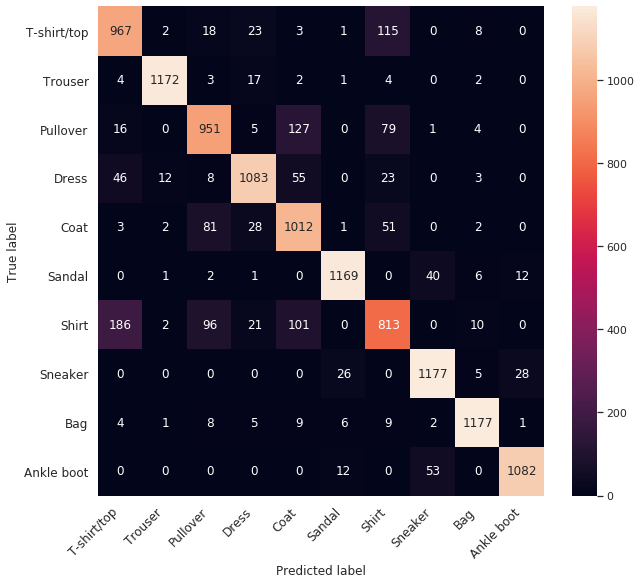

In [61]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

### 2.4. F1-scores

In [0]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [0]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {harmonic_mean_of_positive_values(f1_score):.4f}")
    print(f"Combined Precision: {harmonic_mean_of_positive_values(precision):.4f}")
    print(f"Combined Recall:    {harmonic_mean_of_positive_values(recall):.4f}")
    print()
    print(f"Accuracy:           {accuracy_score(ys, ys_pred):.4f}")

In [64]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8378  |  0.7995  |  0.8182
Class 1 (Trouser):       0.9848  |  0.9710  |  0.9779
Class 2 (Pullover):      0.8479  |  0.7777  |  0.8113
Class 3 (Dress):         0.8716  |  0.9220  |  0.8961
Class 4 (Coat):          0.8054  |  0.8347  |  0.8198
Class 5 (Sandal):        0.9625  |  0.9594  |  0.9609
Class 6 (Shirt):         0.7138  |  0.7429  |  0.7281
Class 7 (Sneaker):       0.9422  |  0.9498  |  0.9460
Class 8 (Bag):           0.9634  |  0.9689  |  0.9661
Class 9 (Ankle boot):    0.9622  |  0.9538  |  0.9580

Combined F1 score:  0.8800
Combined Precision: 0.8806
Combined Recall:    0.8794

Accuracy:           0.8887


In [65]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8403  |  0.8654  |  0.8527
Class 1 (Trouser):       0.9949  |  0.9768  |  0.9858
Class 2 (Pullover):      0.8502  |  0.8588  |  0.8545
Class 3 (Dress):         0.9074  |  0.9317  |  0.9194
Class 4 (Coat):          0.8470  |  0.8585  |  0.8527
Class 5 (Sandal):        0.9900  |  0.9651  |  0.9774
Class 6 (Shirt):         0.7743  |  0.7258  |  0.7493
Class 7 (Sneaker):       0.9504  |  0.9757  |  0.9629
Class 8 (Bag):           0.9741  |  0.9853  |  0.9797
Class 9 (Ankle boot):    0.9736  |  0.9634  |  0.9684

Combined F1 score:  0.9035
Combined Precision: 0.9040
Combined Recall:    0.9030

Accuracy:           0.9109


In [66]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8183  |  0.7960  |  0.8070
Class 1 (Trouser):       0.9791  |  0.9743  |  0.9767
Class 2 (Pullover):      0.8117  |  0.7980  |  0.8048
Class 3 (Dress):         0.8916  |  0.9024  |  0.8970
Class 4 (Coat):          0.8152  |  0.8339  |  0.8245
Class 5 (Sandal):        0.9680  |  0.9342  |  0.9508
Class 6 (Shirt):         0.7002  |  0.7258  |  0.7127
Class 7 (Sneaker):       0.9139  |  0.9620  |  0.9373
Class 8 (Bag):           0.9708  |  0.9509  |  0.9607
Class 9 (Ankle boot):    0.9616  |  0.9390  |  0.9502

Combined F1 score:  0.8735
Combined Precision: 0.8734
Combined Recall:    0.8735

Accuracy:           0.8822


In [67]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8090  |  0.8496  |  0.8288
Class 1 (Trouser):       0.9849  |  0.9768  |  0.9808
Class 2 (Pullover):      0.8054  |  0.8115  |  0.8084
Class 3 (Dress):         0.8960  |  0.9179  |  0.9068
Class 4 (Coat):          0.8261  |  0.8051  |  0.8155
Class 5 (Sandal):        0.9631  |  0.9553  |  0.9592
Class 6 (Shirt):         0.7307  |  0.7022  |  0.7162
Class 7 (Sneaker):       0.9404  |  0.9571  |  0.9487
Class 8 (Bag):           0.9607  |  0.9607  |  0.9607
Class 9 (Ankle boot):    0.9654  |  0.9486  |  0.9569

Combined F1 score:  0.8794
Combined Precision: 0.8798
Combined Recall:    0.8791

Accuracy:           0.8888


In [68]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7887  |  0.8505  |  0.8185
Class 1 (Trouser):       0.9832  |  0.9726  |  0.9779
Class 2 (Pullover):      0.8149  |  0.8039  |  0.8094
Class 3 (Dress):         0.9155  |  0.8805  |  0.8976
Class 4 (Coat):          0.7731  |  0.8576  |  0.8132
Class 5 (Sandal):        0.9613  |  0.9496  |  0.9555
Class 6 (Shirt):         0.7431  |  0.6615  |  0.7000
Class 7 (Sneaker):       0.9246  |  0.9523  |  0.9382
Class 8 (Bag):           0.9671  |  0.9632  |  0.9651
Class 9 (Ankle boot):    0.9635  |  0.9433  |  0.9533

Combined F1 score:  0.8734
Combined Precision: 0.8743
Combined Recall:    0.8724

Accuracy:           0.8836


### 2.4. <90% explained variance

### 2.4.1. 80% explained variance

In [69]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8008705377578735 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 29us/sample - loss: 0.8987 - accuracy: 0.7050 - val_loss: 0.5621 - val_accuracy: 0.8018
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.5162 - accuracy: 0.8218 - val_loss: 0.4941 - val_accuracy: 0.8269
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4676 - accuracy: 0.8382 - val_loss: 0.4633 - val_accuracy: 0.8389
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4410 - accuracy: 0.8470 - val_loss: 0.4443 - val_accuracy: 0.8468
Epoch 5/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.4213 - accuracy: 0.8540 - val_loss: 0.4315 - val_accuracy: 0.8494
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4091 - accuracy: 0.8582 - val_loss: 0.4251 - val_accuracy: 0.8511
Epoch 7/64
48000/48000 [===========

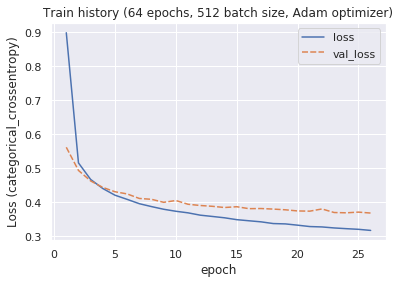

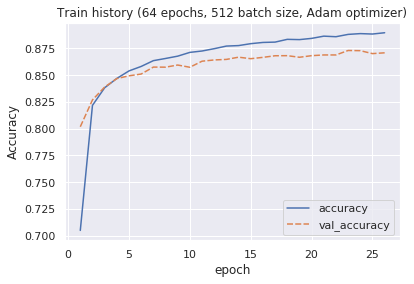

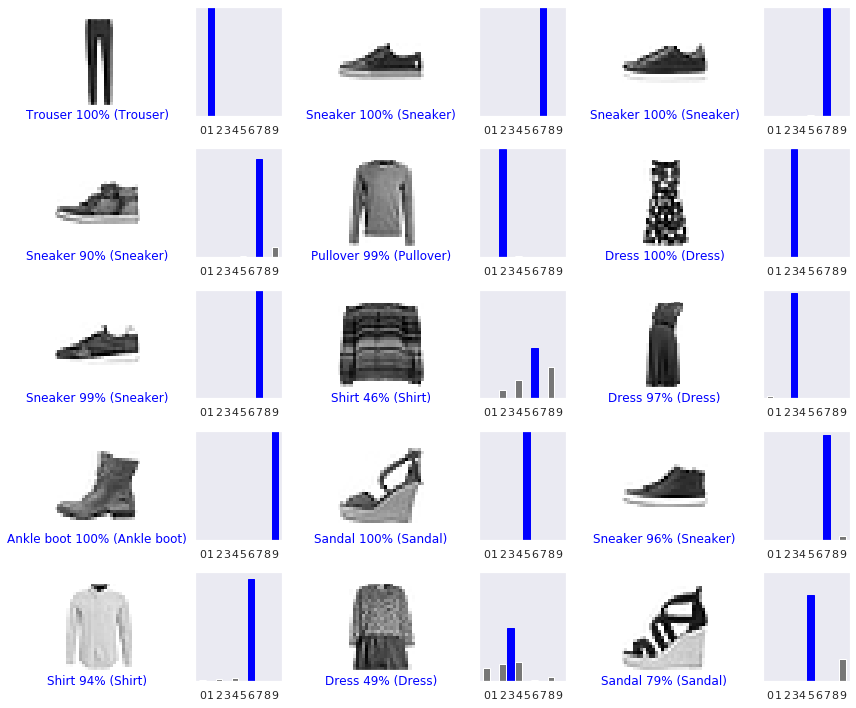

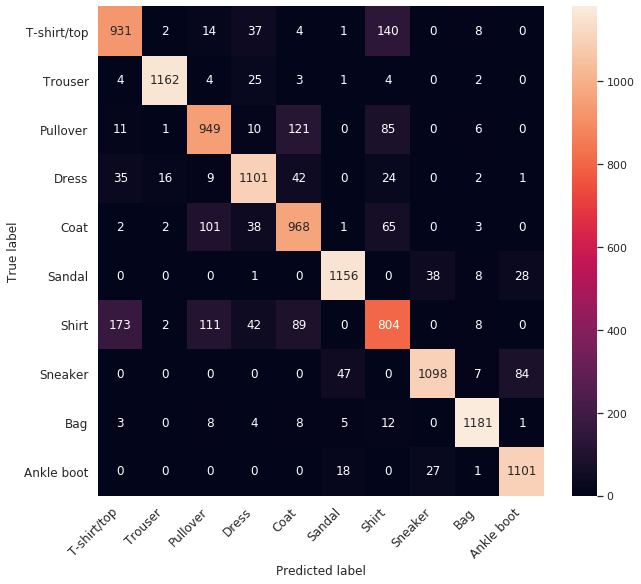

In [70]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [71]:
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8033  |  0.8188  |  0.8110
Class 1 (Trouser):       0.9806  |  0.9643  |  0.9724
Class 2 (Pullover):      0.7935  |  0.8022  |  0.7978
Class 3 (Dress):         0.8752  |  0.8951  |  0.8850
Class 4 (Coat):          0.7838  |  0.8203  |  0.8017
Class 5 (Sandal):        0.9406  |  0.9391  |  0.9398
Class 6 (Shirt):         0.7090  |  0.6542  |  0.6805
Class 7 (Sneaker):       0.9441  |  0.8883  |  0.9154
Class 8 (Bag):           0.9633  |  0.9664  |  0.9649
Class 9 (Ankle boot):    0.9062  |  0.9599  |  0.9323

Combined F1 score:  0.8600
Combined Precision: 0.8607
Combined Recall:    0.8594

Accuracy:           0.8709


### 2.4.2. 60% explained variance

In [72]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6156876087188721 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 30us/sample - loss: 1.0553 - accuracy: 0.6298 - val_loss: 0.7851 - val_accuracy: 0.7088
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7544 - accuracy: 0.7171 - val_loss: 0.7331 - val_accuracy: 0.7207
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7254 - accuracy: 0.7235 - val_loss: 0.7152 - val_accuracy: 0.7249
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7076 - accuracy: 0.7297 - val_loss: 0.7017 - val_accuracy: 0.7294
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.6961 - accuracy: 0.7344 - val_loss: 0.6966 - val_accuracy: 0.7299
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.6873 - accuracy: 0.7377 - val_loss: 0.6857 - val_accuracy: 0.7388
Epoch 7/64
48000/48000 [===========

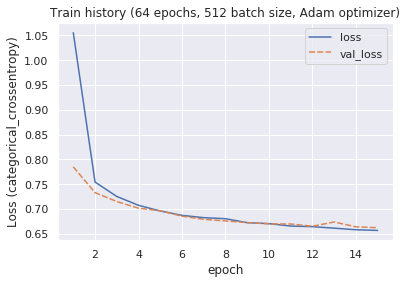

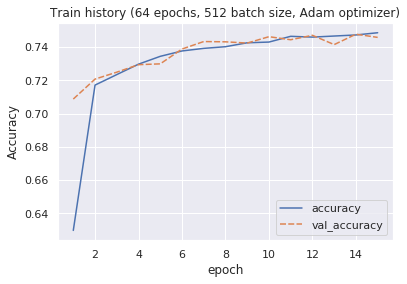

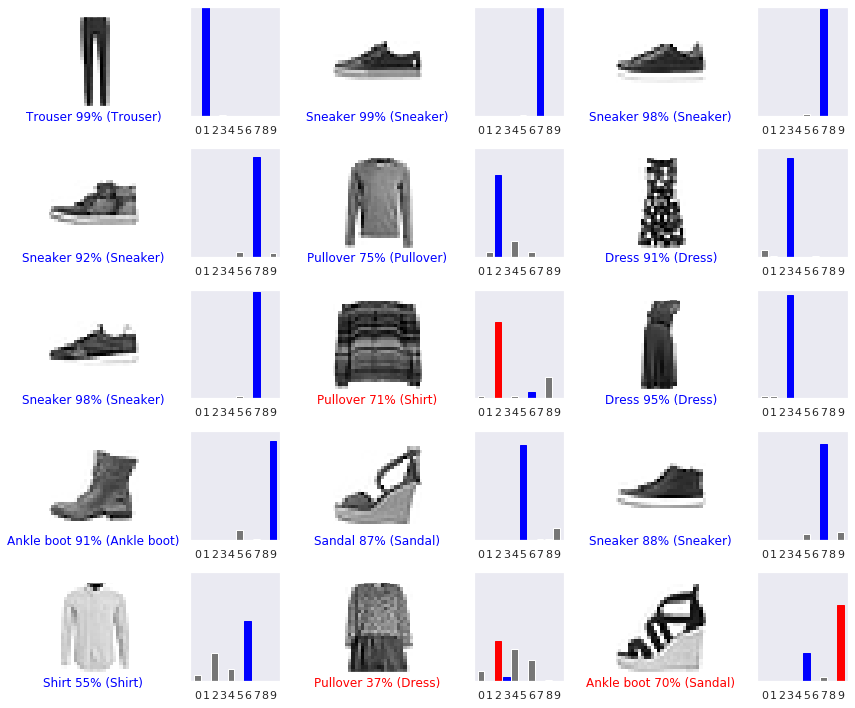

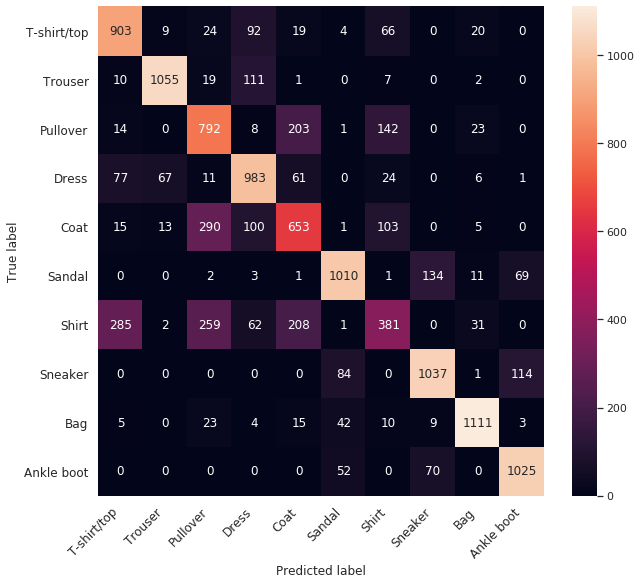

In [73]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [74]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.6898  |  0.7942  |  0.7383
Class 1 (Trouser):       0.9206  |  0.8755  |  0.8975
Class 2 (Pullover):      0.5577  |  0.6695  |  0.6085
Class 3 (Dress):         0.7212  |  0.7992  |  0.7582
Class 4 (Coat):          0.5624  |  0.5534  |  0.5579
Class 5 (Sandal):        0.8452  |  0.8205  |  0.8326
Class 6 (Shirt):         0.5191  |  0.3100  |  0.3882
Class 7 (Sneaker):       0.8296  |  0.8390  |  0.8343
Class 8 (Bag):           0.9182  |  0.9092  |  0.9137
Class 9 (Ankle boot):    0.8457  |  0.8936  |  0.8690

Combined F1 score:  0.6923
Combined Precision: 0.7102
Combined Recall:    0.6753

Accuracy:           0.7458


### 2.5. Plot the first principal components

Out of curiosity, let's visualize the first 2 and 3 components.

In [0]:
pca_3pc = PCA(n_components=3)

In [0]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [77]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2896 (cumulative sum: 0.29)
PC 2: 0.1775 (cumulative sum: 0.47)
PC 3: 0.0606 (cumulative sum: 0.53)


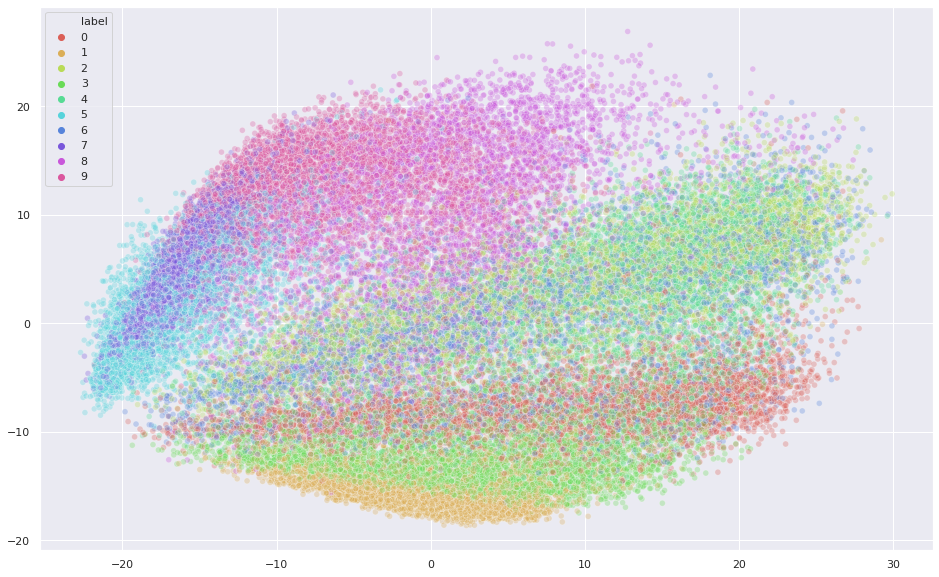

In [78]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [0]:
from mpl_toolkits.mplot3d import Axes3D

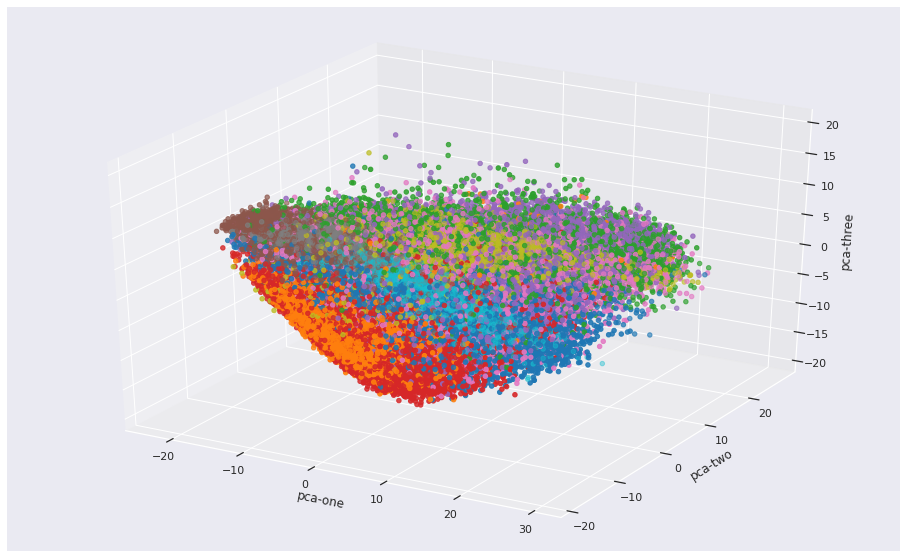

In [80]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [0]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

In [0]:
def build_autoencoder(latent_dim):
    __input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
    __encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
    __decoded = Dense(784, activation='sigmoid')(__encoded)

    autoencoder = Model(__input, __decoded)
    print("\nAutoencoder summary:")
    print(autoencoder.summary())

    encoder = Model(__input, __encoded)
    print("\nEncoder summary:")
    print(encoder.summary())

    # create a placeholder for an encoded (24-dimensional) input
    encoded_input = Input(shape=(latent_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    print("\nDecoder summary:")
    print(decoder.summary())

    autoencoder.compile(optimizer='adam', loss='mse')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

    autoencoder.fit(X_train, X_train,
                    validation_data=(X_val, X_val),
                    epochs=MAX_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=TF_VERBOSE)
    return autoencoder, encoder, decoder

In [0]:
def show_autoencoder_samples(encoder, decoder):
    encoded_imgs = encoder.predict(X_val)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
def train_ae_model(encoder, latent_dim, model_name):
    model = keras.Sequential([
        Input(shape=(latent_dim, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)

    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_ae, best_model_ae = train(model, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred, best_model_ae

### 3.1. Latent vector size of 84

In [0]:
latent_dim = 84

In [86]:
autoencoder_84, encoder_84, decoder_84 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                65940     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               66640     
Total params: 132,580
Trainable params: 132,580
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                6594

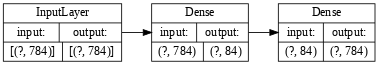

In [87]:
tf.keras.utils.plot_model(autoencoder_84, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

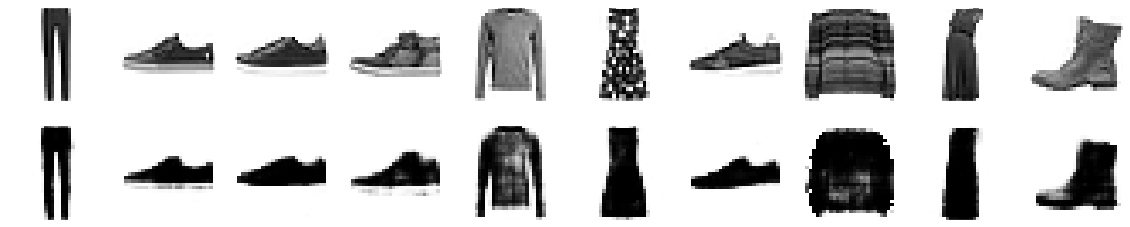

In [88]:
show_autoencoder_samples(encoder_84, decoder_84)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.7946 - accuracy: 0.7311 - val_loss: 0.5144 - val_accuracy: 0.8219
Epoch 2/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.4729 - accuracy: 0.8364 - val_loss: 0.4510 - val_accuracy: 0.8419
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4261 - accuracy: 0.8512 - val_loss: 0.4268 - val_accuracy: 0.8478
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3992 - accuracy: 0.8618 - val_loss: 0.4088 - val_accuracy: 0.8555
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3783 - accuracy: 0.8688 - val_loss: 0.3998 - val_accuracy: 0.8581
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3648 - accuracy: 0.8733 - val_loss: 0.3898 - val_accuracy: 0.8633
Epoch 7/64
48000/48000 [===========

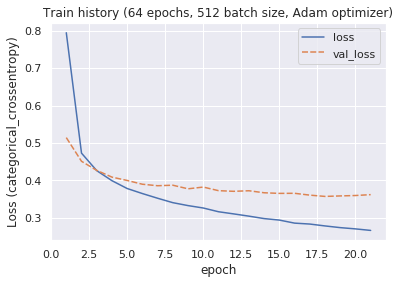

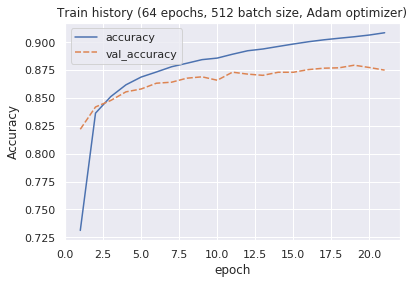

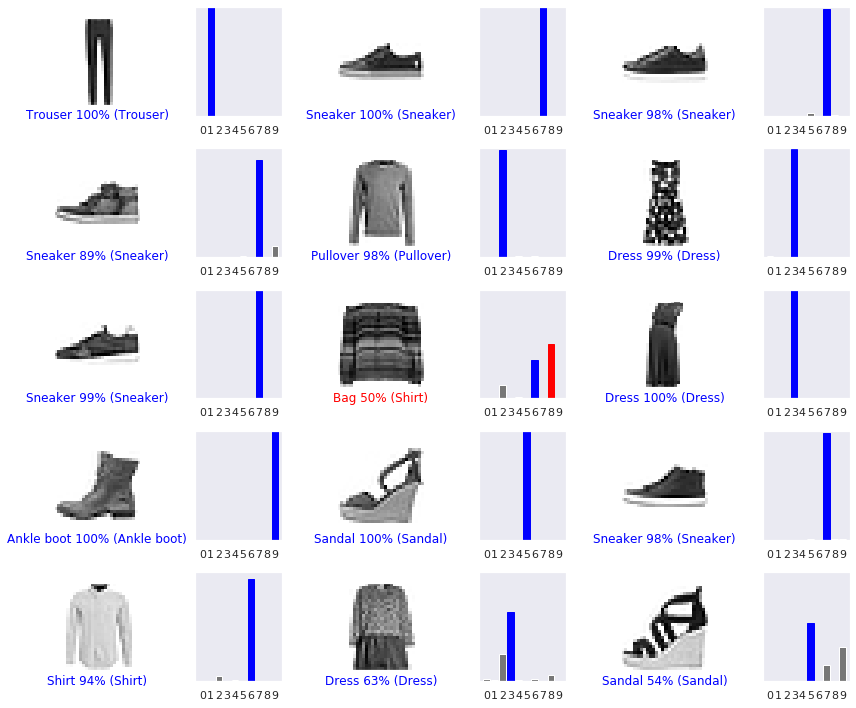

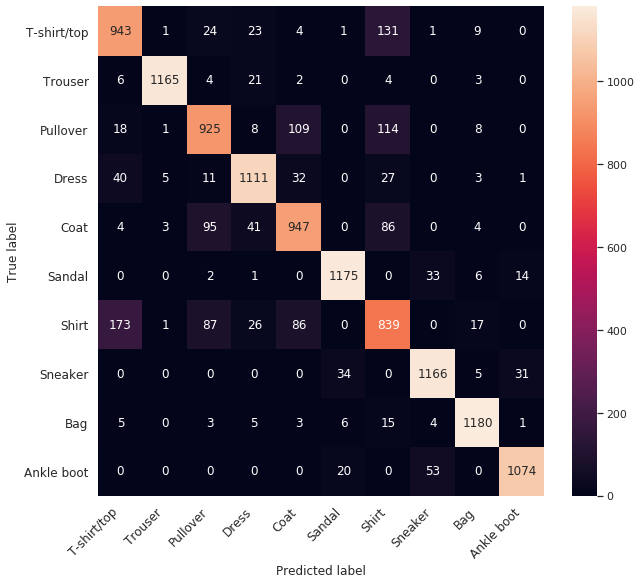

In [89]:
Y_val_ae_84_pred, model_ae_84 = train_ae_model(encoder_84, latent_dim, model_name="AE_84")

In [90]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_84_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7931  |  0.8294  |  0.8108
Class 1 (Trouser):       0.9906  |  0.9668  |  0.9786
Class 2 (Pullover):      0.8036  |  0.7819  |  0.7926
Class 3 (Dress):         0.8989  |  0.9033  |  0.9011
Class 4 (Coat):          0.8005  |  0.8025  |  0.8015
Class 5 (Sandal):        0.9506  |  0.9545  |  0.9526
Class 6 (Shirt):         0.6900  |  0.6827  |  0.6863
Class 7 (Sneaker):       0.9276  |  0.9434  |  0.9354
Class 8 (Bag):           0.9555  |  0.9656  |  0.9605
Class 9 (Ankle boot):    0.9581  |  0.9364  |  0.9471

Combined F1 score:  0.8660
Combined Precision: 0.8661
Combined Recall:    0.8659

Accuracy:           0.8771


### 3.2. Latent vector size of 24

In [0]:
latent_dim = 24

In [92]:
autoencoder_24, encoder_24, decoder_24 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                18840     
_________________________________________________________________
dense_25 (Dense)             (None, 784)               19600     
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                1884

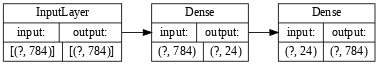

In [93]:
tf.keras.utils.plot_model(autoencoder_24, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

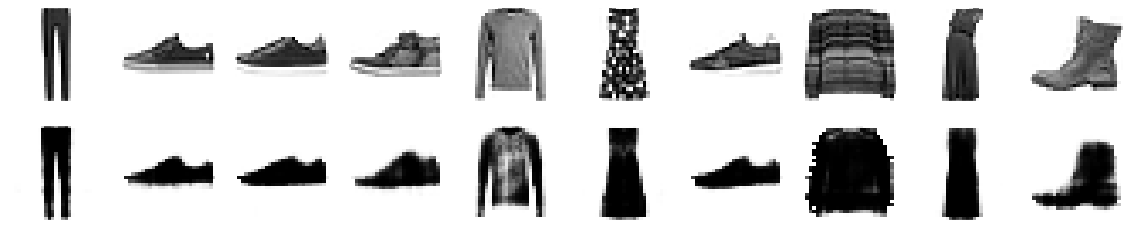

In [94]:
show_autoencoder_samples(encoder_24, decoder_24)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 1.0195 - accuracy: 0.6750 - val_loss: 0.5869 - val_accuracy: 0.7924
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.5314 - accuracy: 0.8127 - val_loss: 0.5075 - val_accuracy: 0.8218
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4836 - accuracy: 0.8291 - val_loss: 0.4779 - val_accuracy: 0.8322
Epoch 4/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.4595 - accuracy: 0.8370 - val_loss: 0.4604 - val_accuracy: 0.8359
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4446 - accuracy: 0.8422 - val_loss: 0.4674 - val_accuracy: 0.8344
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4306 - accuracy: 0.8482 - val_loss: 0.4486 - val_accuracy: 0.8403
Epoch 7/64
48000/48000 [===========

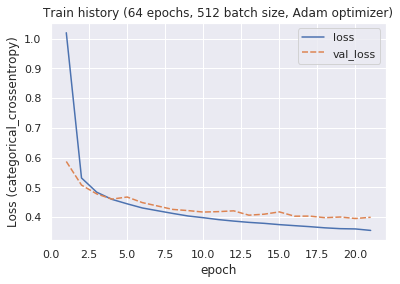

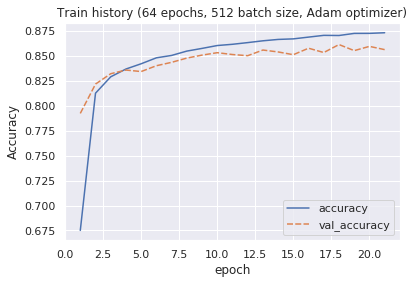

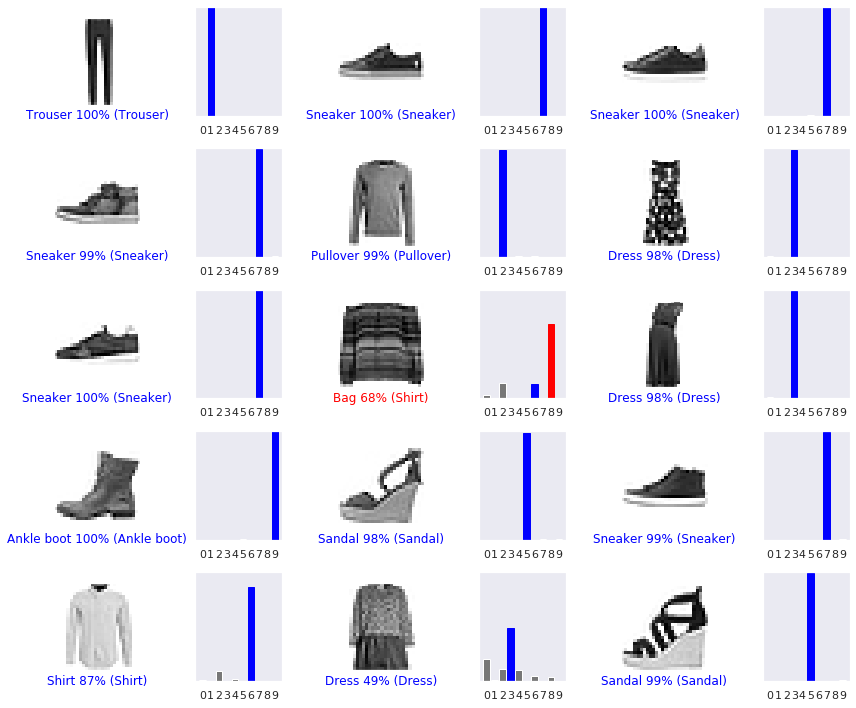

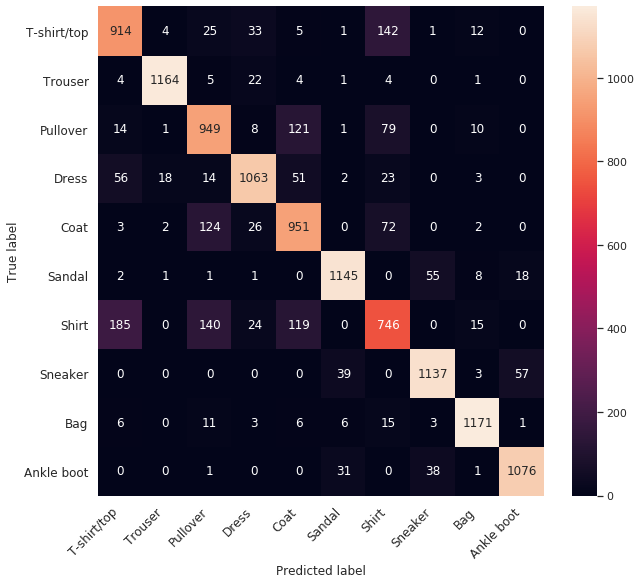

In [95]:
Y_val_ae_24_pred, model_ae_24 = train_ae_model(encoder_24, latent_dim, model_name="AE_24")

In [96]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_24_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7720  |  0.8039  |  0.7876
Class 1 (Trouser):       0.9782  |  0.9660  |  0.9720
Class 2 (Pullover):      0.7472  |  0.8022  |  0.7737
Class 3 (Dress):         0.9008  |  0.8642  |  0.8822
Class 4 (Coat):          0.7566  |  0.8059  |  0.7805
Class 5 (Sandal):        0.9339  |  0.9301  |  0.9320
Class 6 (Shirt):         0.6901  |  0.6070  |  0.6459
Class 7 (Sneaker):       0.9214  |  0.9199  |  0.9206
Class 8 (Bag):           0.9551  |  0.9583  |  0.9567
Class 9 (Ankle boot):    0.9340  |  0.9381  |  0.9361

Combined F1 score:  0.8455
Combined Precision: 0.8467
Combined Recall:    0.8444

Accuracy:           0.8597


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, v_measure_score # require ground-truth label knowledge
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [0]:
def show_clusters(clusters, data):
    # [-1.0, 1.0], with 1.0 being the perfect score, and 0.0 being random
    print(f"Adjusted Rand Score:     {adjusted_rand_score(labels_true=ys_val, labels_pred=clusters.labels_):.4f}")
    # [0.0, 1.0], harmonic mean between homogeneity and completeness scores (higher is better)
    print(f"V-measure Score:         {v_measure_score(labels_true=ys_val, labels_pred=clusters.labels_):.4f}")
    # [-1.0, 1.0], with 1.0 for highly dense clustering, 0.0 indicate overlapping clusters, and -1.0 for incorrect clustering
    print(f"Silhouette Coefficient:  {silhouette_score(X=data, labels=clusters.labels_):.4f}")
    # the score is higher when clusters are dense and well separated
    print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X=data, labels=clusters.labels_):.1f}")
    # 0.0 is the lowest possible score, with values closer to it indicating a better partition
    print(f"Davies-Bouldin Index:    {davies_bouldin_score(X=data, labels=clusters.labels_):.4f}")

    labels = clusters.labels_.astype(float)
    # we select the first two feature columns for plotting in 2D
    __xs, __ys = data[..., 0], data[..., 1]

    try:
        centroids = clusters.cluster_centers_ # K-Means and Mini-Batch K-Means
        __xc, __yc = centroids[..., 0], centroids[..., 1]
    except:
        centroids = None
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=__xs, y=__ys, 
                    hue=labels, palette=sns.color_palette("hls", 10), alpha=0.3)
    if centroids is not None:
        sns.scatterplot(x=__xc, y=__yc, 
                        marker='+', s=175, linewidths=3, color='black', zorder=10)
    plt.show()

Let's standardize the features we'll be using for clustering with Z-score:

In [99]:
reduced_features_list = [("X_val_80var", pca_80var.transform(X_val)), ("X_val_90var", pca_90var.transform(X_val))]
                      # [("X_val_ae_24", encoder_24.predict(X_val)), ("X_val_ae_84", encoder_84.predict(X_val))]
reduced_features_zscore = []
for name, reduced_features in reduced_features_list:
    print(f"{name+':':<19} {str(reduced_features.shape):<11} "
          f"| min: {reduced_features.min():>6.2f} | max: {reduced_features.max():>6.2f} "
          f"| mean: {reduced_features.mean():>6.3f} | std: {reduced_features.std():>6.3f}")
    reduced_features_zscore.append((name + "_zscore", (reduced_features - reduced_features.mean()) / reduced_features.std()))
for name, reduced_features in reduced_features_zscore:
    print(f"{name+':':<19} {str(reduced_features.shape):<11} "
          f"| min: {reduced_features.min():>6.2f} | max: {reduced_features.max():>6.2f} "
          f"| mean: {reduced_features.mean():>6.3f} | std: {reduced_features.std():>6.3f}")

X_val_80var:        (12000, 24) | min: -22.32 | max:  30.72 | mean: -0.003 | std:  4.271
X_val_90var:        (12000, 84) | min: -22.32 | max:  30.72 | mean: -0.001 | std:  2.421
X_val_80var_zscore: (12000, 24) | min:  -5.23 | max:   7.19 | mean:  0.000 | std:  1.000
X_val_90var_zscore: (12000, 84) | min:  -9.22 | max:  12.69 | mean:  0.000 | std:  1.000


In [0]:
X_val_80var_zscore, X_val_90var_zscore = reduced_features_zscore[0][1], reduced_features_zscore[1][1]

## 4.1. K-Means

### 4.1.1. PCA reduced features (90% explained variance, 84 principal components)

Adjusted Rand Score:     0.3731
V-measure Score:         0.5189
Silhouette Coefficient:  0.1679
Calinski-Harabasz Index: 1922.9
Davies-Bouldin Index:    1.6639


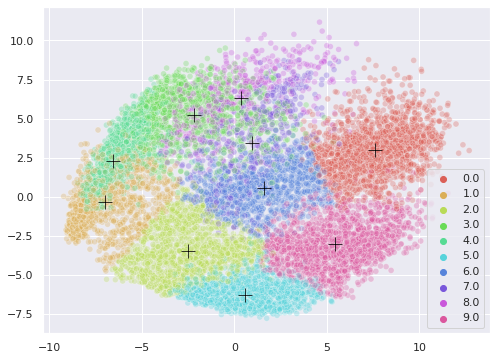

In [101]:
kmeans_pca_90var = KMeans(n_clusters=10).fit(X_val_90var_zscore)
show_clusters(kmeans_pca_90var, X_val_90var_zscore)

### 4.1.2. PCA reduced features (80% explained variance, 24 principal components)

Adjusted Rand Score:     0.3458
V-measure Score:         0.5089
Silhouette Coefficient:  0.2367
Calinski-Harabasz Index: 2669.1
Davies-Bouldin Index:    1.3282


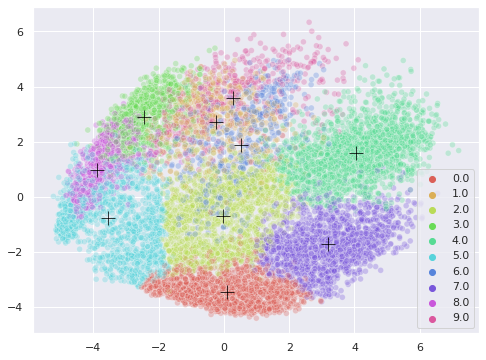

In [102]:
kmeans_pca_80var = KMeans(n_clusters=10).fit(X_val_80var_zscore)
show_clusters(kmeans_pca_80var, X_val_80var_zscore)

## 4.2. Mini-Batch K-Means

### 4.2.1. PCA reduced features (90% explained variance, 84 principal components)

Adjusted Rand Score:     0.3373
V-measure Score:         0.5042
Silhouette Coefficient:  0.1862
Calinski-Harabasz Index: 1944.7
Davies-Bouldin Index:    1.5686


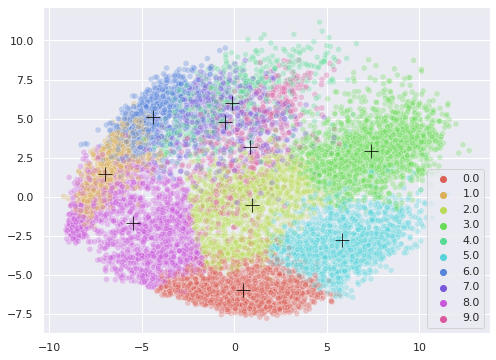

In [103]:
mbkmeans_pca_90var = MiniBatchKMeans(n_clusters=10).fit(X_val_90var_zscore)
show_clusters(mbkmeans_pca_90var, X_val_90var_zscore)

### 4.2.2. PCA reduced features (80% explained variance, 24 principal components)

Adjusted Rand Score:     0.3494
V-measure Score:         0.5160
Silhouette Coefficient:  0.2324
Calinski-Harabasz Index: 2647.1
Davies-Bouldin Index:    1.3434


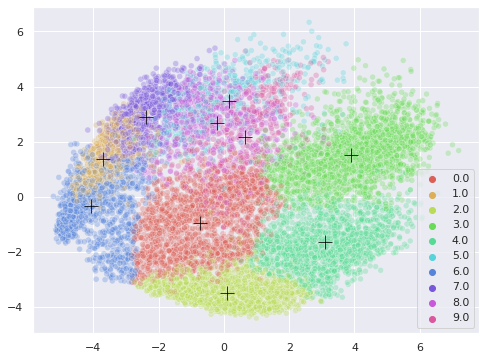

In [104]:
mbkmeans_pca_80var = MiniBatchKMeans(n_clusters=10).fit(X_val_80var_zscore)
show_clusters(mbkmeans_pca_80var, X_val_80var_zscore)

## 4.3. Agglomerative clustering

### 4.3.1. PCA reduced features (90% explained variance, 84 principal components)

Adjusted Rand Score:     0.3420
V-measure Score:         0.4995
Silhouette Coefficient:  0.1476
Calinski-Harabasz Index: 1649.8
Davies-Bouldin Index:    1.8602


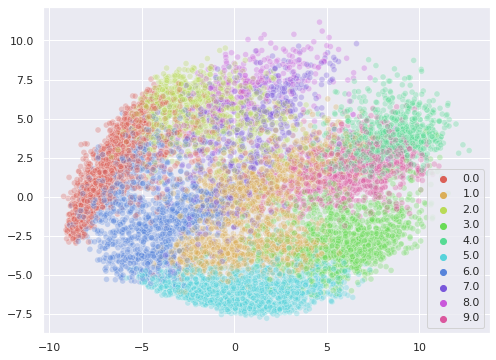

In [105]:
agglomerative_pca_90var = AgglomerativeClustering(n_clusters=10).fit(X_val_90var_zscore)
show_clusters(agglomerative_pca_90var, X_val_90var_zscore)

### 4.3.2. PCA reduced features (80% explained variance, 24 principal components)

Adjusted Rand Score:     0.3830
V-measure Score:         0.5481
Silhouette Coefficient:  0.1835
Calinski-Harabasz Index: 2253.7
Davies-Bouldin Index:    1.5920


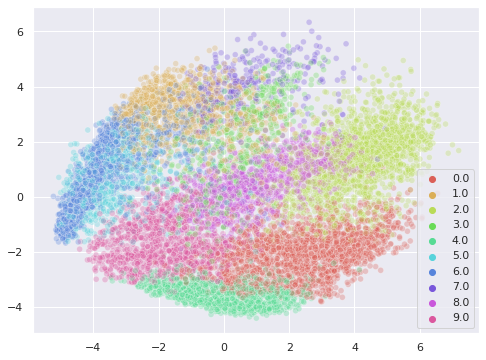

In [106]:
agglomerative_pca_80var = AgglomerativeClustering(n_clusters=10).fit(X_val_80var_zscore)
show_clusters(agglomerative_pca_80var, X_val_80var_zscore)

## 5. Running the test set on our best model
Since our best network was the baseline CNN (considering both validation accuracy and combined F1 score), let's at last try it out on the Fashion MNIST test set.

In [107]:
# NOTE we are using the mean and std values from the training data to normalize the test set

X_test = (xs_test - mean) / std
print(f"xs_test: mean={xs_test.mean():>8.4f}, stddev={xs_test.std():>7.4f}")
print(f"X_test:  mean={X_test.mean():>8.4f}, stddev={X_test.std():>7.4f}") # mean should (hopefully) be close to 0 and stddev close to 1

xs_test: mean=  0.2869, stddev= 0.3540
X_test:  mean=  0.0020, stddev= 1.0032


In [108]:
Y_test = onehot_encode(ys_test)
print(ys_test.shape, Y_test.shape)

(10000,) (10000, 10)


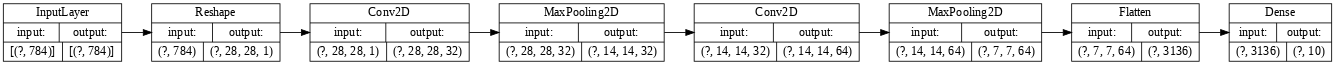

In [109]:
tf.keras.utils.plot_model(best_conv_model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

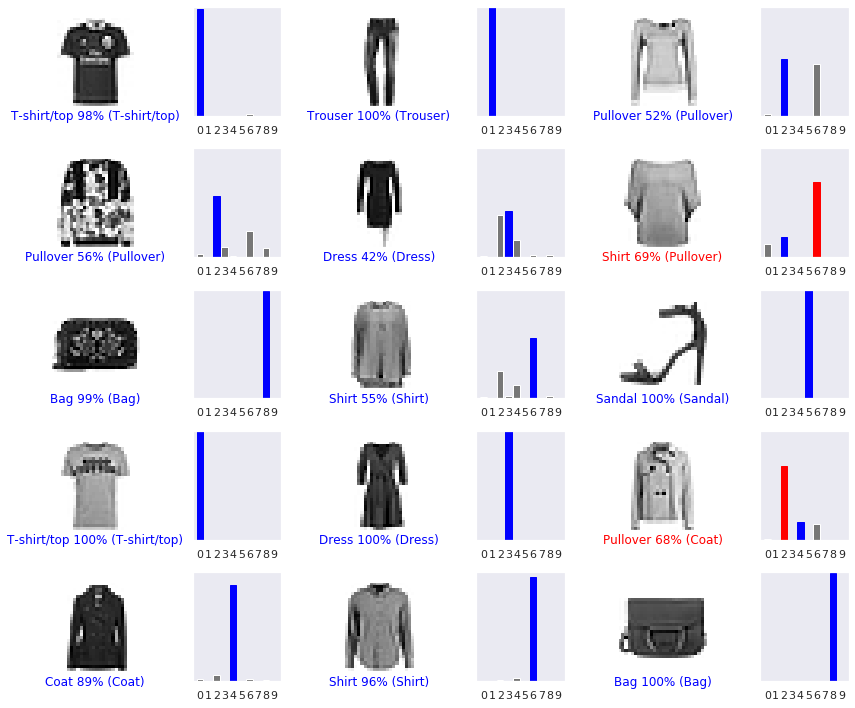

In [110]:
Y_test_pred = best_conv_model.predict(X_test)
plot_image_with_prediction(X_test, ys_test, Y_test_pred)

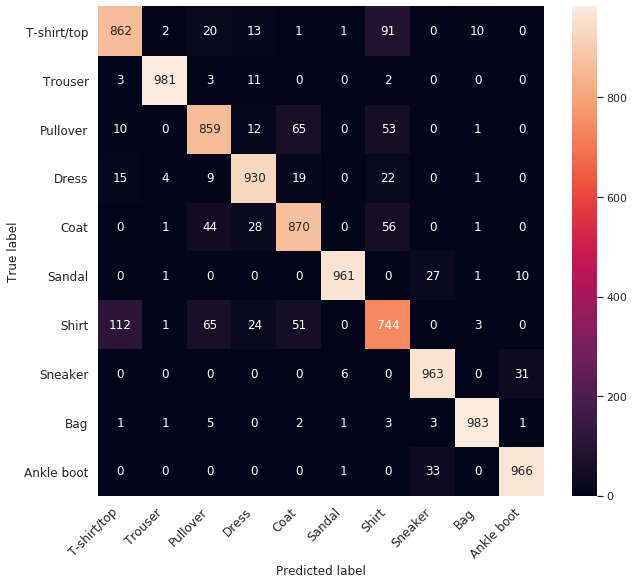

In [111]:
print_cm(ys_test, np.argmax(Y_test_pred, axis=1), CLASS_NAME)

In [112]:
print_f1_scores(ys_test, np.argmax(Y_test_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8594  |  0.8620  |  0.8607
Class 1 (Trouser):       0.9899  |  0.9810  |  0.9854
Class 2 (Pullover):      0.8547  |  0.8590  |  0.8569
Class 3 (Dress):         0.9136  |  0.9300  |  0.9217
Class 4 (Coat):          0.8631  |  0.8700  |  0.8665
Class 5 (Sandal):        0.9907  |  0.9610  |  0.9756
Class 6 (Shirt):         0.7662  |  0.7440  |  0.7549
Class 7 (Sneaker):       0.9386  |  0.9630  |  0.9506
Class 8 (Bag):           0.9830  |  0.9830  |  0.9830
Class 9 (Ankle boot):    0.9583  |  0.9660  |  0.9622

Combined F1 score:  0.9057
Combined Precision: 0.9060
Combined Recall:    0.9055

Accuracy:           0.9119


In [0]:
from sklearn.metrics import accuracy_score

In [114]:
print(f"Accuracy on the test set: {accuracy_score(ys_test, np.argmax(Y_test_pred, axis=1))}")

Accuracy on the test set: 0.9119


In [115]:
strftime('%X')

'20:55:27'